In [100]:
# importing libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats
from sklearn.metrics import precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.compose import ColumnTransformer

# model preprocessing libraries 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

In [101]:
# reading data for model preprocessing 
gamers_df = pd.read_csv('Data/preprocessed_data',index_col=0)
gamers_df

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,Game,Platform,...,Age,Work,Degree,Birthplace,Residence,Playstyle,GAD_T,Residence_ISO3,Birthplace_ISO3,anxiety
S. No.,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",...,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,1,USA,USA,minimal anxiety
2,1,2,2,2,0,1,0,Somewhat difficult,Other,PC,...,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,8,USA,USA,mild anxiety
3,0,2,2,0,0,3,1,Not difficult at all,Other,PC,...,32,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,8,DEU,DEU,mild anxiety
4,0,0,0,0,0,0,0,Not difficult at all,Other,PC,...,28,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,0,USA,USA,minimal anxiety
5,2,1,2,2,2,3,2,Very difficult,Other,"Console (PS, Xbox, ...)",...,19,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,14,KOR,USA,moderate anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,1,0,0,1,0,1,1,Not difficult at all,Other,"Console (PS, Xbox, ...)",...,22,Student at college / university,Master (or equivalent),France,France,Multiplayer - online - with strangers,4,FRA,FRA,minimal anxiety
14247,3,3,3,3,2,3,3,Extremely difficult,League of Legends,PC,...,20,Student at college / university,High school diploma (or equivalent),USA,USA,Multiplayer - online - with strangers,20,USA,USA,severe anxiety
14248,0,0,0,0,0,0,0,Not difficult at all,Starcraft 2,PC,...,19,Student at college / university,High school diploma (or equivalent),Norway,Norway,Multiplayer - online - with real life friends,0,NOR,NOR,minimal anxiety


In [102]:
gamers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12058 entries, 1 to 14250
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GAD1             12058 non-null  int64  
 1   GAD2             12058 non-null  int64  
 2   GAD3             12058 non-null  int64  
 3   GAD4             12058 non-null  int64  
 4   GAD5             12058 non-null  int64  
 5   GAD6             12058 non-null  int64  
 6   GAD7             12058 non-null  int64  
 7   GADE             11468 non-null  object 
 8   Game             12058 non-null  object 
 9   Platform         12058 non-null  object 
 10  Hours            12036 non-null  float64
 11  earnings         12058 non-null  object 
 12  whyplay          12058 non-null  object 
 13  streams          11977 non-null  float64
 14  Gender           12058 non-null  object 
 15  Age              12058 non-null  int64  
 16  Work             12024 non-null  object 
 17  Degree      

In [103]:
gamers_df.isna().sum()

GAD1                 0
GAD2                 0
GAD3                 0
GAD4                 0
GAD5                 0
GAD6                 0
GAD7                 0
GADE               590
Game                 0
Platform             0
Hours               22
earnings             0
whyplay              0
streams             81
Gender               0
Age                  0
Work                34
Degree               0
Birthplace           0
Residence            0
Playstyle            0
GAD_T                0
Residence_ISO3      88
Birthplace_ISO3     93
anxiety              0
dtype: int64

### Data Preprocessing Workflow 

From our earlier EDA work, we identified several different strategies for dealing with NaN values in our dataset. 
- `GADE` NaN values should be imputed with "Did not answer"
- `Hours` NaN values should be imputed using the `IterativeImputer` class
- `streams` NaN values should be imputed with 0 
- `Work` NaN values should be imputed using the `IterativeImputer` class
- `Residence_ISO3` and `Birthplace_ISO3` NaN values should be imputed with 'AAA' to reflect 'Unknown' values in their corresponding columns. 

In [104]:
# splitting our dataset to predictor and target variables
X = gamers_df.drop(columns=['anxiety'])
y = gamers_df['anxiety']

In [105]:
# viewing the distribution of class values 
y.value_counts(normalize=True)

minimal anxiety     0.555067
mild anxiety        0.271355
moderate anxiety    0.119506
severe anxiety      0.054072
Name: anxiety, dtype: float64

In [106]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [107]:
# train-test splitting our data before imputation 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

## Building a Baseline Model 

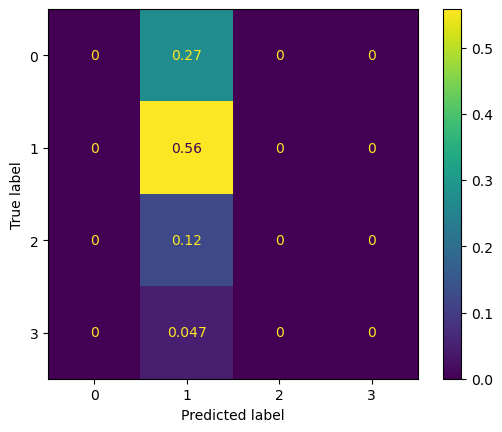

In [108]:
dummy_clf = DummyClassifier(strategy='most_frequent',random_state=42)
dummy_clf.fit(X_train,y_train)
y_pred = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='all')

In [ ]:
,

In [87]:
X_train.isna().sum()

GAD1                 0
GAD2                 0
GAD3                 0
GAD4                 0
GAD5                 0
GAD6                 0
GAD7                 0
GADE               446
Game                 0
Platform             0
Hours               19
earnings             0
whyplay              0
streams             67
Gender               0
Age                  0
Work                28
Degree               0
Birthplace           0
Residence            0
Playstyle            0
GAD_T                0
Residence_ISO3      70
Birthplace_ISO3     70
dtype: int64

In [88]:
# replacing NaN values in GADE with 'Did not answer'
X_train['GADE'].fillna('Did not answer',inplace=True)
X_train['GADE'].value_counts()

Not difficult at all    4183
Somewhat difficult      3466
Very difficult           678
Did not answer           446
Extremely difficult      270
Name: GADE, dtype: int64

In [89]:
X_train['Residence_ISO3'].fillna('AAA',inplace=True)

In [90]:
X_train['Birthplace_ISO3'].fillna('AAA',inplace=True)

In [50]:
X_train['Work'].value_counts(dropna=False)

Student at college / university    4779
Employed                           1848
Student at school                  1478
Unemployed / between jobs           913
NaN                                  25
Name: Work, dtype: int64

In [9]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy = 'mean')), ('numnorm', StandardScaler())])
numeric_pipeline

Pipeline(steps=[('numimputer', SimpleImputer()), ('numnorm', StandardScaler())])